# Applying PCA in SVM without insights from ensemble learning

In [22]:
import pickle
import pandas as pd 
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Considering all Features

In [23]:
data = pd.read_csv("./data/cleveland_final.csv")
y = data['num']
pcaCandidates = data.drop(["num"],axis=1)

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

(282, 3)


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,pca1,pca2,pca3
count,282.000000,282.000000,282.000000
mean,-303.854387,-93.297234,258.129483
std,1.105385,1.061300,1.609324
min,-306.232877,-95.974112,253.262180
25%,-304.642514,-94.052938,257.138868
50%,-303.930993,-93.434474,258.198424
75%,-303.231462,-92.580648,259.063855
max,-297.840822,-90.207163,262.510483


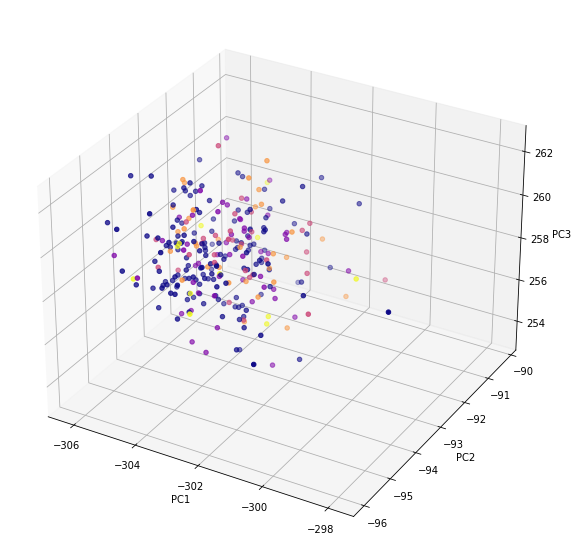

In [25]:
scaling=StandardScaler()
 
scaling.fit(pcaCandidates)
Scaled_data=scaling.transform(pcaCandidates)
 

principal=PCA(n_components=3)
principal.fit(pcaCandidates)
# principal.fit(Scaled_data)
postPCA=principal.transform(Scaled_data)

print(postPCA.shape)

fig = pyplot.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(postPCA[:,0], postPCA[:,1], postPCA[:,2], c=y,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

postPCA = pd.DataFrame(postPCA, columns=['pca1', 'pca2', 'pca3'])
postPCA.describe()

### Analysis

It is visible these columns have least contribution towards the classification objective

In [26]:
data =  pd.concat([y, postPCA], axis=1)
print(data.shape)
data.describe()

(282, 4)


,num,pca1,pca2,pca3
count,282.000000,282.000000,282.000000,282.000000
mean,0.907801,-303.854387,-93.297234,258.129483
std,1.224894,1.105385,1.061300,1.609324
min,0.000000,-306.232877,-95.974112,253.262180
25%,0.000000,-304.642514,-94.052938,257.138868
50%,0.000000,-303.930993,-93.434474,258.198424
75%,2.000000,-303.231462,-92.580648,259.063855
max,4.000000,-297.840822,-90.207163,262.510483


In [27]:
y = data.num.values
x = data.drop(["num"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)
print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (197, 3)
x_test (85, 3)
y_train (197,)
y_test (85,)


In [28]:
param_grid = [{'kernel': ['linear'], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]}, 
              {'kernel': ['poly'], 'gamma': [0.01, 0.001, 0.0001], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]}, 
              {'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]},
              {'kernel': ['sigmoid'], 'gamma': [0.01, 0.001, 0.0001]}
             ]

from sklearn.metrics import precision_score, make_scorer, recall_score


precision_scorer = make_scorer(precision_score, zero_division=0, average='macro')
# recall_scorer = make_scorer(recall_score, average='macro')

scores = ['precision', 'accuracy', 'f1', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    if score == 'precision':
        clf = GridSearchCV(SVC(), param_grid, scoring=precision_scorer, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')  
    elif score == 'accuracy':
        clf = GridSearchCV(SVC(), param_grid, scoring=score, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')
    else: 
        clf = GridSearchCV(SVC(), param_grid, scoring ='%s_macro' %score, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')
        
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']          
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#          print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      0.98      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.54        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.54      0.39        85


# Tuning hyper-parameters for accuracy


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.55        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.55      0.39        85


# Tuning hyper-parameters for f1


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      0.98      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.54        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.54      0.39        85


# Tuning hyper-parameters for recall


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      0.98      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.54        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.54      0.39        85




/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## 55% Post PCA feedback accuracy for SVM

In [29]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier 

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
# create the sub models
estimatorsh = []
estimatorss = []
model1 = DecisionTreeClassifier()
model2 = SVC(kernel= 'linear', C=1)
model3 = AdaBoostClassifier(n_estimators=300)

estimatorsh.append(('svm', model2))
estimatorsh.append(('dt', model1))
estimatorsh.append(('abc', model3))


model1 = DecisionTreeClassifier()
model2 = SVC(kernel= 'linear', C=1, probability=True)
model3 = AdaBoostClassifier(n_estimators=300)

estimatorss.append(('svm', model2))
estimatorss.append(('dt', model1))
estimatorss.append(('abc', model3))


# create the ensemble model
hensemble = VotingClassifier(estimatorsh, voting ='hard')
sensemble = VotingClassifier(estimatorss, voting ='soft')

              precision    recall  f1-score   support

           0       0.57      0.89      0.69        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       1.00      0.08      0.14        13
           4       0.00      0.00      0.00         5

    accuracy                           0.51        85
   macro avg       0.31      0.19      0.17        85
weighted avg       0.47      0.51      0.41        85



/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

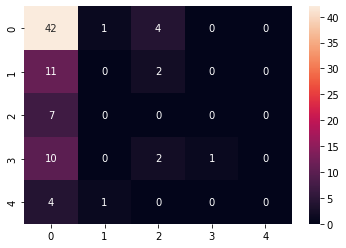

In [30]:
hensemble.fit(x_train, y_train)
y_pred = hensemble.predict(x_test)
accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60        47
           1       0.17      0.23      0.19        13
           2       0.06      0.14      0.09         7
           3       0.20      0.08      0.11        13
           4       0.00      0.00      0.00         5

    accuracy                           0.38        85
   macro avg       0.21      0.21      0.20        85
weighted avg       0.41      0.38      0.39        85



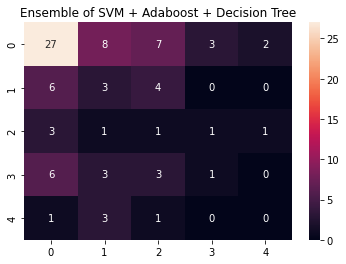

In [31]:
sensemble.fit(x_train, y_train)
y_pred = sensemble.predict(x_test)
accuracy_score(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred)
pyplot.title("Ensemble of SVM + Adaboost + Decision Tree")
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_pred))

## 92% Post PCA feedback loop accuracy for ensemble

(282, 3)


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,pca1,pca2,pca3
count,282.000000,282.000000,282.000000
mean,353.168787,149.435840,143.538949
std,1.118043,0.945389,0.931073
min,350.340610,147.407252,140.967626
25%,352.413566,148.775401,142.940923
50%,353.134171,149.285912,143.541721
75%,353.815403,150.062030,144.083150
max,356.436491,152.517916,148.506490


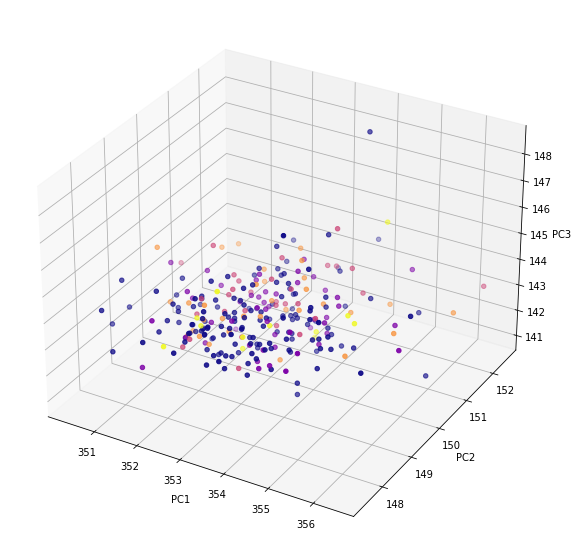

In [32]:
y_num = data['num']
data = data.drop(["num"],axis=1)

scaling=StandardScaler()
scaling.fit(data)
Scaled_data=scaling.transform(data)


principal=PCA(n_components=3)
principal.fit(data)
# principal.fit(Scaled_data)
postPCA=principal.transform(Scaled_data)

print(postPCA.shape)

fig = pyplot.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(postPCA[:,0], postPCA[:,1], postPCA[:,2], c=y_num,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

postPCA = pd.DataFrame(postPCA, columns=['pca1', 'pca2', 'pca3'])
postPCA.describe()

In [33]:
data =  pd.concat([y_num, postPCA], axis=1)
print(data.shape)
data.describe()


(282, 4)


,num,pca1,pca2,pca3
count,282.000000,282.000000,282.000000,282.000000
mean,0.907801,353.168787,149.435840,143.538949
std,1.224894,1.118043,0.945389,0.931073
min,0.000000,350.340610,147.407252,140.967626
25%,0.000000,352.413566,148.775401,142.940923
50%,0.000000,353.134171,149.285912,143.541721
75%,2.000000,353.815403,150.062030,144.083150
max,4.000000,356.436491,152.517916,148.506490


In [34]:
y = data.num.values
x = data.drop(["num"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)
print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (197, 3)
x_test (85, 3)
y_train (197,)
y_test (85,)


In [35]:
param_grid = [{'kernel': ['linear'], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]}, 
              {'kernel': ['poly'], 'gamma': [0.01, 0.001, 0.0001], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]}, 
              {'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001], 'C': [100, 10, 1.0, 0.1, 0.01, 0.001]},
              {'kernel': ['sigmoid'], 'gamma': [0.01, 0.001, 0.0001]}
             ]

from sklearn.metrics import precision_score, make_scorer, recall_score


precision_scorer = make_scorer(precision_score, zero_division=0, average='macro')
# recall_scorer = make_scorer(recall_score, average='macro')

scores = ['precision', 'accuracy', 'f1', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    if score == 'precision':
        clf = GridSearchCV(SVC(), param_grid, scoring=precision_scorer, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')  
    elif score == 'accuracy':
        clf = GridSearchCV(SVC(), param_grid, scoring=score, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')
    else: 
        clf = GridSearchCV(SVC(), param_grid, scoring ='%s_macro' %score, cv=StratifiedKFold(n_splits=6), refit = 'accuracy')
        
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']          
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#          print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.55        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.55      0.39        85


# Tuning hyper-parameters for accuracy


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.55        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.55      0.39        85


# Tuning hyper-parameters for f1


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.55        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.55      0.39        85


# Tuning hyper-parameters for recall


/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         5

    accuracy                           0.55        85
   macro avg       0.11      0.20      0.14        85
weighted avg       0.31      0.55      0.39        85




/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/meivenkatkumar/fyp/fyp1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [36]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier 

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
# create the sub models
estimatorsh = []
estimatorss = []
model1 = DecisionTreeClassifier()
model2 = SVC(kernel= 'linear', C=1)
model3 = AdaBoostClassifier(n_estimators=300)

estimatorsh.append(('svm', model2))
estimatorsh.append(('dt', model1))
estimatorsh.append(('abc', model3))


model1 = DecisionTreeClassifier()
model2 = SVC(kernel= 'linear', C=1, probability=True)
model3 = AdaBoostClassifier(n_estimators=300)

estimatorss.append(('svm', model2))
estimatorss.append(('dt', model1))
estimatorss.append(('abc', model3))


# create the ensemble model
hensemble = VotingClassifier(estimatorsh, voting ='hard')
sensemble = VotingClassifier(estimatorss, voting ='soft')

              precision    recall  f1-score   support

           0       0.57      0.91      0.70        47
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         7
           3       0.50      0.08      0.13        13
           4       0.00      0.00      0.00         5

    accuracy                           0.52        85
   macro avg       0.21      0.20      0.17        85
weighted avg       0.39      0.52      0.41        85



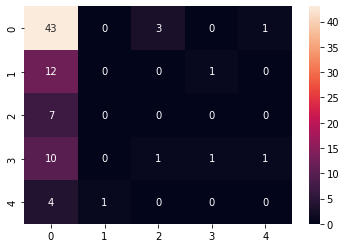

In [37]:
hensemble.fit(x_train, y_train)
y_pred = hensemble.predict(x_test)
accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61        47
           1       0.15      0.15      0.15        13
           2       0.07      0.14      0.09         7
           3       0.25      0.08      0.12        13
           4       0.00      0.00      0.00         5

    accuracy                           0.39        85
   macro avg       0.21      0.20      0.19        85
weighted avg       0.40      0.39      0.39        85



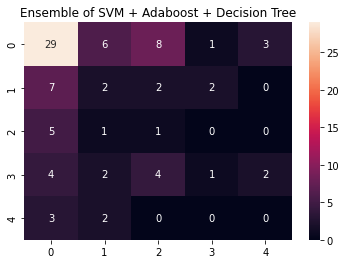

In [38]:
sensemble.fit(x_train, y_train)
y_pred = sensemble.predict(x_test)
accuracy_score(y_test, y_pred)


cm = confusion_matrix(y_test, y_pred)
pyplot.title("Ensemble of SVM + Adaboost + Decision Tree")
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_pred))

## 39% for soft ensemble